In [ ]:
import os
import shutil
import glob
import pandas as pd
import matplotlib.pyplot as plt
import re

import numpy as np
import math

plt.rcParams["font.size"] = 25
plt.rcParams['font.sans-serif'] = ['Arial']


In [ ]:
############################################################ Read data for file_types
# fileの分岐を確認
file_types = ['Chem.CSV', 'Param.CSV', 'Goal.CSV'] # Path_Df[5].unique() 

path_untill_2 = '../0_Data/1_Rietveld/'
Path_List = glob.glob(path_untill_2+"*/*/*.CSV")
Path_Df = pd.DataFrame([path.split("/") for path in Path_List])

display(Path_List)
"""
データの中身
'Chem.CSV'   ['File', 'Sample', 'Sample ID', 'Phase', 'Phase Quantity', 'Oxide','Quantity (wt-%)']
'Param.CSV'  
['File', 'Sample', 'Sample ID', 'Phase', 'Refined Composition', 'A',
       'ESD(A)', 'B', 'ESD(B)', 'C', 'ESD(C)', 'ALPHA', 'ESD(ALPHA)', 'BETA',
       'ESD(BETA)', 'GAMMA', 'ESD(GAMMA)', 'GrainSize(1,1,1)',
       'ESD(GrainSize(1,1,1))']

'Goal.CSV'   ['File', 'Sample', 'Sample ID', 'Parameter, Goal', 'Value', 'ESD']
"""

rock_type = Path_Df[4].unique() # ['Pelitic', 'Mafic']
instrument_type = Path_Df[3].unique() # ['Laboratory', 'SPring-8']

# Compile df
Chem_df = pd.DataFrame()
Param_df = pd.DataFrame()
Goal_df = pd.DataFrame()
df_list = [Chem_df, Param_df, Goal_df]

'''
# File read
for path_0 in Path_Df[0].unique():
    for path_1 in Path_Df[1].unique():
        for path_2 in Path_Df[2].unique(): 
            # ここまでは同じ分岐
'''

# Chem.CSV compile
file_type='Chem.CSV'
for path_3 in Path_Df[3].unique(): # ['Laboratory', 'SPring-8']
    for path_4 in Path_Df[4].unique(): # ['Pelitic', 'Mafic']
        # Pathの記録
        path_csv = path_untill_2+"/"+path_3+"/"+path_4+"/"+file_type

        ######### Dataのread、整理
        data_read = pd.read_csv(path_csv, sep=';')
        data_read["Instrument"] = path_3 # Instrument typeを記録
        data_read["Rock_Type"] = path_4 # Instrument typeを記録
        ######### Dataのread、整理
        Chem_df = pd.concat([data_read, Chem_df]) 

# 'Param.CSV' compile
file_type='Param.CSV'
for path_3 in Path_Df[3].unique(): # ['Laboratory', 'SPring-8']
    for path_4 in Path_Df[4].unique(): # ['Pelitic', 'Mafic']
        # Pathの記録
        path_csv = path_untill_2+"/"+path_3+"/"+path_4+"/"+file_type

        ######### Dataのread、整理
        data_read = pd.read_csv(path_csv, sep=';')
        data_read["Instrument"] = path_3 # Instrument typeを記録
        data_read["Rock_Type"] = path_4 # Instrument typeを記録
        ######### Dataのread、整理
        Param_df = pd.concat([data_read, Param_df]) 

# Goal.CSV compile
file_type='Goal.CSV'
for path_3 in Path_Df[3].unique(): # ['Laboratory', 'SPring-8']
    for path_4 in Path_Df[4].unique(): # ['Pelitic', 'Mafic']
        # Pathの記録
        path_csv = path_untill_2+"/"+path_3+"/"+path_4+"/"+file_type

        ######### Dataのread、整理
        data_read = pd.read_csv(path_csv, sep=';')
        data_read["Instrument"] = path_3 # Instrument typeを記録
        data_read["Rock_Type"] = path_4 # Instrument typeを記録
        ######### Dataのread、整理
        Goal_df = pd.concat([data_read, Goal_df]) 
############################################################ Read data for file_types


['../0_Data/1_Rietveld/Laboratory/Pelitic/Chem.CSV',
 '../0_Data/1_Rietveld/Laboratory/Pelitic/Param.CSV',
 '../0_Data/1_Rietveld/Laboratory/Pelitic/Goal.CSV',
 '../0_Data/1_Rietveld/Laboratory/Mafic/Chem.CSV',
 '../0_Data/1_Rietveld/Laboratory/Mafic/Param.CSV',
 '../0_Data/1_Rietveld/Laboratory/Mafic/Goal.CSV',
 '../0_Data/1_Rietveld/SPring-8/Pelitic/Chem.CSV',
 '../0_Data/1_Rietveld/SPring-8/Pelitic/Param.CSV',
 '../0_Data/1_Rietveld/SPring-8/Pelitic/Goal.CSV',
 '../0_Data/1_Rietveld/SPring-8/Mafic/Chem.CSV',
 '../0_Data/1_Rietveld/SPring-8/Mafic/Param.CSV',
 '../0_Data/1_Rietveld/SPring-8/Mafic/Goal.CSV']

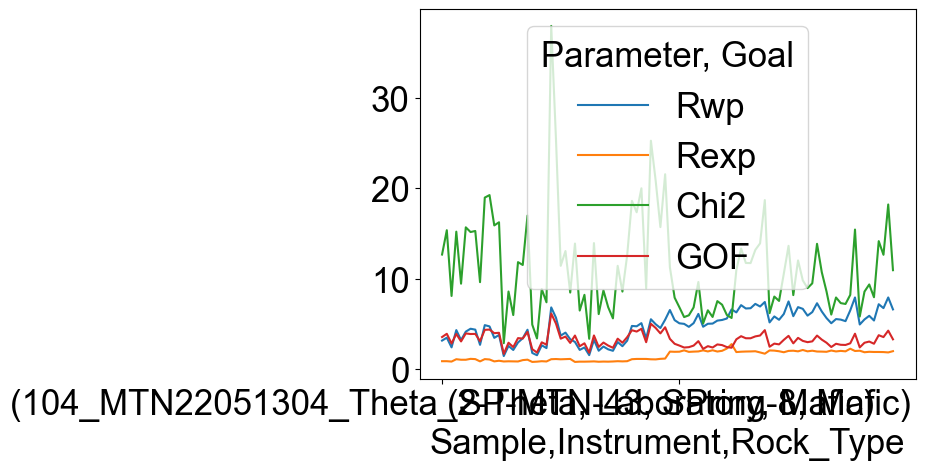

In [ ]:
# Chem
############################################################ Bulk chemical composition compile
pivot_chem_df = Chem_df.pivot_table(index=['Sample', "Instrument", "Rock_Type", "Phase", "Phase Quantity"], columns='Oxide', values='Quantity (wt-%)') # compile mode
pivot_bulk_comp_df = pivot_chem_df.loc[pivot_chem_df.index.get_level_values("Phase") == "Weighted total"]
############################################################ Bulk chemical composition compile

# Param
############################################################ Compile Mineral Parameter
important_param_sample = ['Sample', "Instrument", "Rock_Type", "Phase",]
important_param_value = ['A','B','C','ALPHA','BETA','GAMMA'] # 結晶の情報をコンパイル

Param_compile_df = Param_df[important_param_sample+important_param_value] #.fillna(0)
############################################################ Compile Mineral Parameter

# Goal
############################################################ Bulk mode compile
pivot_bulk_mode_df = Goal_df.pivot_table(index=['Sample', "Instrument", "Rock_Type"], columns='Parameter, Goal', values='Value') # compile mode
pivot_bulk_mode_df = pivot_bulk_mode_df.fillna(0)

# 誤差の可視化
# 誤差リスト
error_col = ['Rwp', 'Rexp', 'Chi2', 'GOF']
pivot_error_df = pivot_bulk_mode_df[error_col]
pivot_error_df.plot()

# Not need for mode['Rwp', 'Rexp', 'Chi2', 'GOF']
pivot_bulk_mode_df = pivot_bulk_mode_df.drop(['Rwp', 'Rexp', 'Chi2', 'GOF'], axis=1).fillna(0)
############################################################ Bulk mode compile

#filtered_df = pivot_bulk_mode_df.loc[pivot_bulk_mode_df.index.get_level_values('Instrument') == instrument_name]


# Output df
folder_path = "../0_Data/2_Compiled_Data/"
pivot_chem_df.to_excel(folder_path+"pivot_chem_df.xlsx")
pivot_bulk_comp_df.to_excel(folder_path+"pivot_bulk_comp_df.xlsx")
Param_compile_df.to_excel(folder_path+"Param_compile_df.xlsx")
pivot_error_df.to_excel(folder_path+"pivot_error_df.xlsx")
pivot_bulk_mode_df.to_excel(folder_path+"pivot_bulk_mode_df.xlsx")


<Axes: xlabel='Sample,Instrument,Rock_Type'>

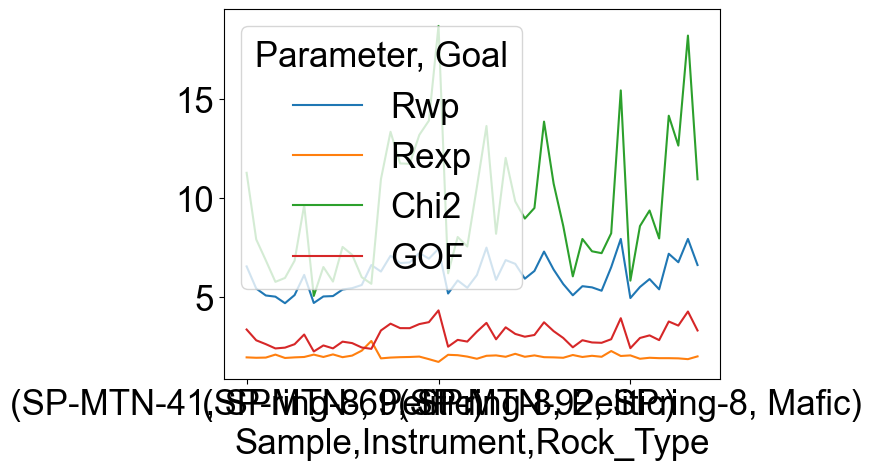

In [ ]:
pivot_error_df.loc[pivot_error_df.index.get_level_values('Instrument') == "SPring-8"].plot()


<Axes: xlabel='Sample,Instrument,Rock_Type'>

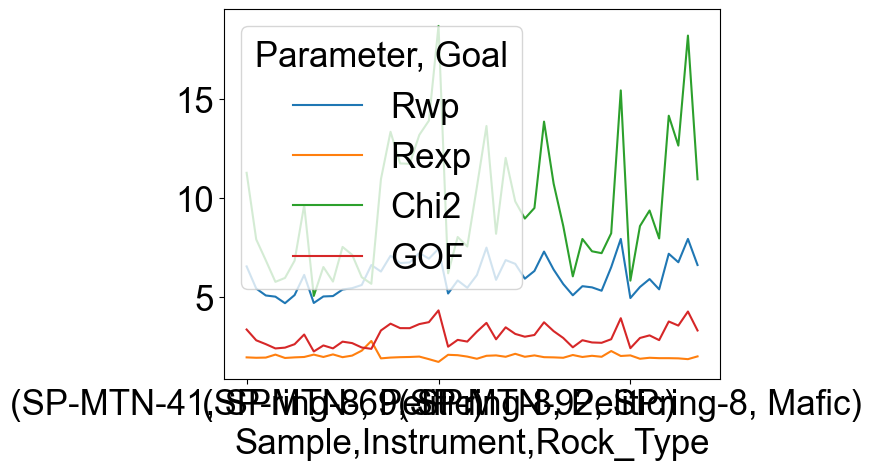

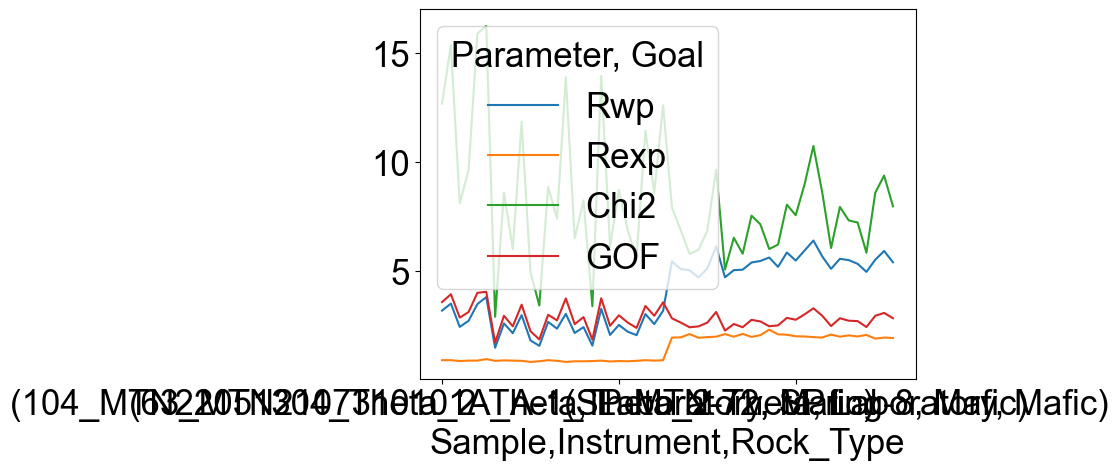

In [ ]:
pivot_error_df.loc[pivot_error_df.index.get_level_values('Instrument') == "SPring-8"].plot()
pivot_error_df.loc[pivot_error_df.index.get_level_values('Rock_Type') == "Mafic"].plot()


In [ ]:
pivot_error_df


,,"Parameter, Goal",Rwp,Rexp,Chi2,GOF
Sample,Instrument,Rock_Type,,,,
104_MTN22051304_Theta_2-Theta,Laboratory,Mafic,3.17,0.89,12.6864,3.5618
105_MTN22051305_Theta_2-Theta,Laboratory,Mafic,3.49,0.89,15.3770,3.9213
106_MTN22051306_Theta_2-Theta,Laboratory,Mafic,2.42,0.85,8.1057,2.8471
107_MTN22051307_Theta_2-Theta,Laboratory,Pelitic,4.33,1.11,15.2170,3.9009
108_MTN22051308_Theta_2-Theta,Laboratory,Pelitic,3.23,1.05,9.4629,3.0762
...,...,...,...,...,...,...
SP-MTN-95,SPring-8,Mafic,5.39,1.91,7.9636,2.8220
SP-MTN-96,SPring-8,Pelitic,7.19,1.91,14.1707,3.7644
SP-MTN-97,SPring-8,Pelitic,6.76,1.90,12.6586,3.5579
